In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# 회귀분석
from statsmodels.formula.api import ols
# 회귀분석 상수항 추가
from statsmodels.api import qqplot, add_constant
# 선형 모델 
import statsmodels.formula.api as smf
# 평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
# data split
from sklearn.model_selection import train_test_split
# 선형 회귀 모형
from sklearn.linear_model import LinearRegression
# 규제화 패키지
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# 변수 선택법
from sklearn.feature_selection import RFE
# Scale 변환
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글 폰트 설정
# !ls -l /usr/share/fonts/truetype/
!rm -rf ~/.cache/matplotlib/*
!fc-cache -fv

import matplotlib    
import matplotlib.font_manager

[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]

/usr/share/fonts: caching, new cache contents: 0 fonts, 6 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/X11/Type1: caching, new cache contents: 8 fonts, 0 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: c

fc-cache: succeeded


['NanumBarunGothic',
 'NanumGothic Eco',
 'NanumSquareRound',
 'NanumBarunpen',
 'NanumGothic',
 'NanumGothic',
 'NanumGothic Eco',
 'NanumSquareRound',
 'NanumSquare',
 'NanumBarunpen',
 'NanumMyeongjo Eco',
 'NanumGothicCoding',
 'Nanum Brush Script',
 'NanumSquareRound',
 'NanumSquareRound',
 'NanumMyeongjo Eco',
 'NanumSquare',
 'NanumGothic',
 'NanumMyeongjo',
 'NanumBarunGothic',
 'NanumMyeongjo Eco',
 'Nanum Pen Script',
 'NanumMyeongjo',
 'NanumGothic Eco',
 'NanumBarunGothic',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumGothicCoding',
 'NanumGothic',
 'NanumGothic Eco',
 'NanumMyeongjo Eco',
 'NanumMyeongjo',
 'NanumBarunpen',
 'NanumGothicCoding',
 'Nanum Brush Script',
 'NanumSquare',
 'NanumMyeongjo',
 'NanumSquareRound',
 'NanumBarunGothic',
 'NanumSquareRound',
 'NanumSquare',
 'NanumGothicCoding',
 'Nanum Pen Script',
 'NanumGothic Eco',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumMyeongjo Eco',
 'NanumGothic',
 'NanumGothic',
 'NanumSqu

In [3]:
# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 전체 적용
plt.rcParams["font.family"] = 'NanumMyeongjo'

# 실습과제 1

## 데이터 불러오기

In [4]:
df = pd.read_csv('/home/piai/Bigdata 실습과제/2. Big Data 분석/체질검사.csv', encoding = 'utf-8')
df.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


#### BMI 및 파생변수 계산
> BMI = 체중 / 키^2  
  
> 신체에서 지방 축적되기 쉬운 곳은 ABDOMEN, HIP, THIGH, FOREARM으로 판단하였다.  
> NECK CHEST KNEE ANKLE BICEPS은 지방이 쌓이기 힘든 신체부위로 판단하였다.  
> BMI 파생변수와 척도를 맞추기 위해서 ABDOMEN, HIP, THIGH, FOREARM의 값을 키의 제곱값으로 나누었다.

In [5]:
# 단위 변환
0.45*df['WEIGHT']
((2.54)/100)*df['HEIGHT']
df['BMI'] = 0.45*df['WEIGHT']/(((2.54)/100)*df['HEIGHT']*((2.54)/100)*df['HEIGHT'])
df['HIPH'] = 0.45*df['HIP']/(((2.54)/100)*df['HEIGHT']*((2.54)/100)*df['HEIGHT'])
df['FOREARMH'] = 0.45*df['FOREARM']/(((2.54)/100)*df['HEIGHT']*((2.54)/100)*df['HEIGHT'])
df['ABDOMENH'] = 0.45*df['ABDOMEN']/(((2.54)/100)*df['HEIGHT']*((2.54)/100)*df['HEIGHT'])
df['THIGHH'] = 0.45*df['THIGH']/(((2.54)/100)*df['HEIGHT']*((2.54)/100)*df['HEIGHT'])
df.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870,19.735579,3.874961,19.789027,11.664970
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595,12.983959,4.121892,10.868055,7.872814
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478,14.612262,3.820296,14.121718,8.175732
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617,14.537119,4.404699,13.940146,8.551247
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165,19.208535,4.955393,20.792217,10.643027


In [6]:
df_merge_left = df.iloc[:,0:2]
df_merge_left.head()

,FAT,AGE
0,35.2,46
1,11.8,27
2,22.2,69
3,10.6,57
4,47.5,51


In [7]:
df_merge_right = df.iloc[:,14:]
df_merge_right.head()

,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
0,48.523870,19.735579,3.874961,19.789027,11.664970
1,23.082595,12.983959,4.121892,10.868055,7.872814
2,26.422478,14.612262,3.820296,14.121718,8.175732
3,23.838617,14.537119,4.404699,13.940146,8.551247
4,37.293165,19.208535,4.955393,20.792217,10.643027


In [8]:
df_new = pd.concat([df_merge_left, df_merge_right], axis = 1)
df_new.columns

Index(['FAT', 'AGE', 'BMI', 'HIPH', 'FOREARMH', 'ABDOMENH', 'THIGHH'], dtype='object')

## 변수 간의 경향성 파악

### 산점도 분석

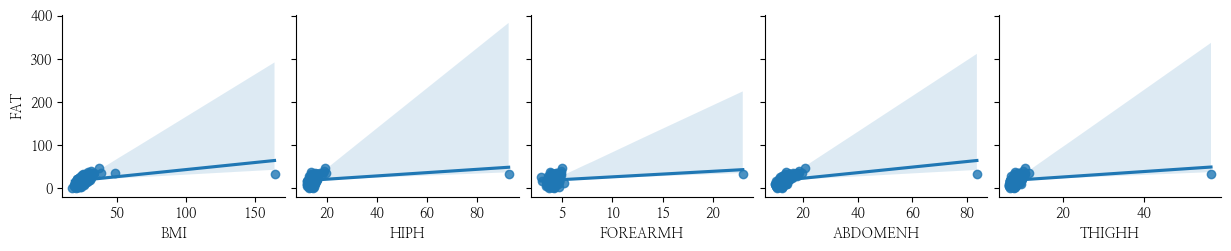

In [9]:
sns.pairplot(df_new, y_vars = 'FAT', x_vars=['BMI', 'HIPH', 'FOREARMH', 'ABDOMENH', 'THIGHH'], kind='reg')

* 이상치로 인해 경향성이 잘 나타나지 않는다.

#### 이상치 제거

In [10]:
df_new['BMI'].sort_index()
df_new.sort_values(by = "BMI", ascending = False, inplace = True)
df_new

,FAT,AGE,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
78,32.9,44,164.306562,92.572722,23.002919,83.595973,56.585577
0,35.2,46,48.523870,19.735579,3.874961,19.789027,11.664970
82,34.5,45,38.774160,18.534860,4.825557,18.623403,10.698864
4,47.5,51,37.293165,19.208535,4.955393,20.792217,10.643027
117,35.0,65,33.616780,17.115358,4.507194,17.669399,9.179103
...,...,...,...,...,...,...,...
17,15.1,34,19.646938,12.574041,3.676784,11.703962,7.353568
230,10.1,27,19.508426,12.172723,3.514189,9.727489,7.161998
53,5.3,25,19.075544,12.221618,3.344026,10.151507,6.887101
174,7.7,39,18.893177,13.304417,3.484490,11.464123,7.542186


> 78번 data는 다른 data와 달리 키와 몸무게가 FAT지표와 잘 맞지 않는다  
> 따라서 이상치로 판단하여 제거하였다.

In [11]:
df_new['BMI'][78]

164.30656245397523

In [12]:
df_new.drop([78], inplace = True)

In [13]:
df_new.reset_index(drop = True, inplace = True)
df_new

,FAT,AGE,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
0,35.2,46,48.523870,19.735579,3.874961,19.789027,11.664970
1,34.5,45,38.774160,18.534860,4.825557,18.623403,10.698864
2,47.5,51,37.293165,19.208535,4.955393,20.792217,10.643027
3,35.0,65,33.616780,17.115358,4.507194,17.669399,9.179103
4,34.3,35,32.959928,16.158668,4.592008,16.736279,10.743565
...,...,...,...,...,...,...,...
246,15.1,34,19.646938,12.574041,3.676784,11.703962,7.353568
247,10.1,27,19.508426,12.172723,3.514189,9.727489,7.161998
248,5.3,25,19.075544,12.221618,3.344026,10.151507,6.887101
249,7.7,39,18.893177,13.304417,3.484490,11.464123,7.542186


#### 제거 후 산점도 분석

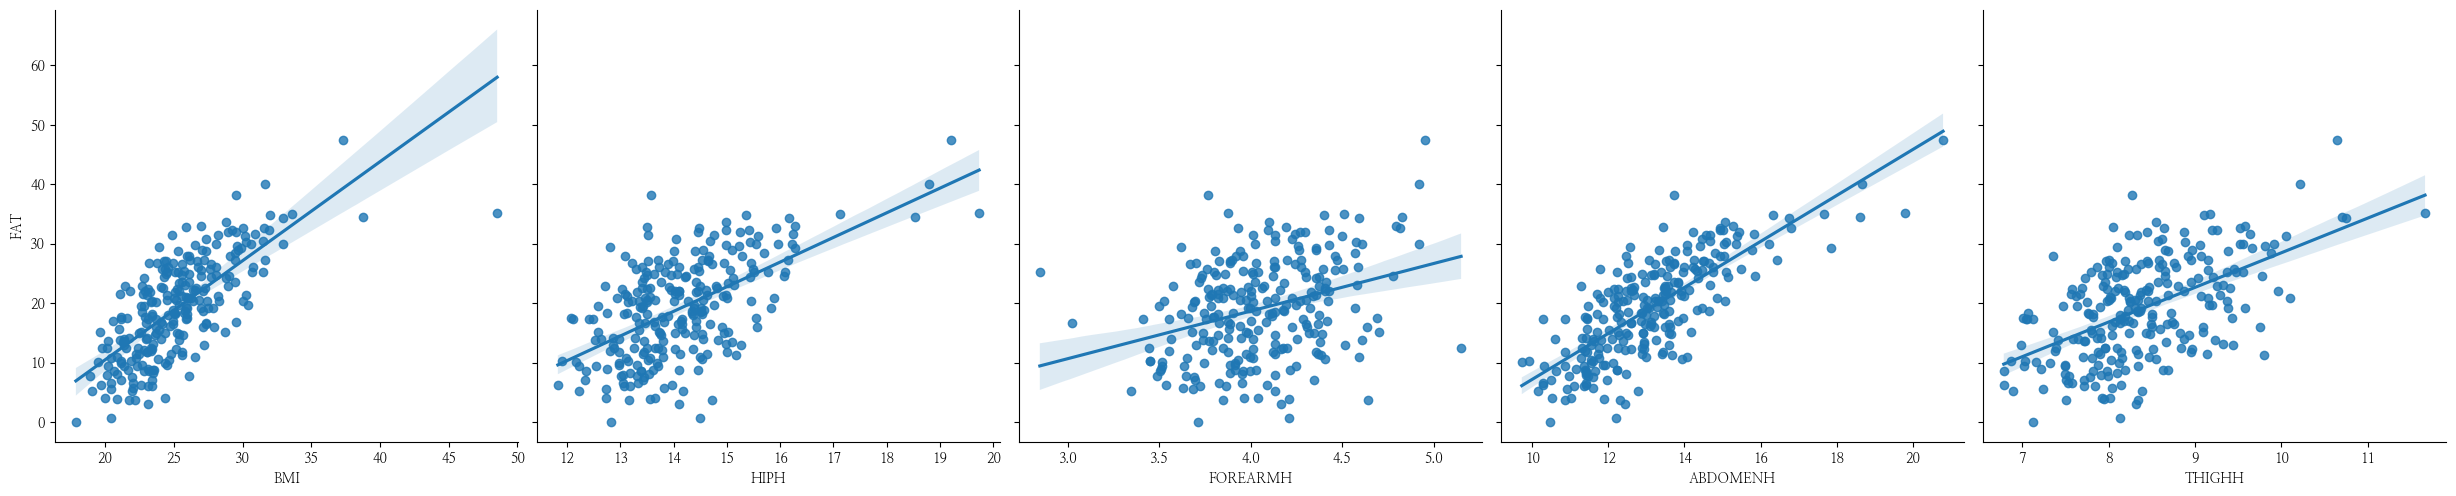

In [14]:
sns.pairplot(df_new, y_vars = 'FAT', x_vars=['BMI', 'HIPH', 'FOREARMH', 'ABDOMENH', 'THIGHH'], kind='reg', height = 5)

* 이상치 제거 후 산점도 분석 결과, BMI data에서 대부분의 표본과 거리가 먼 data 3개를 추가 식별하였고 추가로 제거하였다.

In [15]:
df_new['BMI'].sort_index()
df_new.sort_values(by = "BMI", ascending = False, inplace = True)
df_new.head()

,FAT,AGE,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
0,35.2,46,48.523870,19.735579,3.874961,19.789027,11.664970
1,34.5,45,38.774160,18.534860,4.825557,18.623403,10.698864
2,47.5,51,37.293165,19.208535,4.955393,20.792217,10.643027
3,35.0,65,33.616780,17.115358,4.507194,17.669399,9.179103
4,34.3,35,32.959928,16.158668,4.592008,16.736279,10.743565


In [16]:
df_new.drop(df.index[:3], inplace = True)

In [17]:
df_new.reset_index(drop = True, inplace = True)
# df_new = df_new.iloc[:,2:]
df_new.head()

,FAT,AGE,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
0,35.0,65,33.616780,17.115358,4.507194,17.669399,9.179103
1,34.3,35,32.959928,16.158668,4.592008,16.736279,10.743565
2,29.9,37,32.915490,15.540204,4.024899,15.049030,9.523321
3,34.8,44,31.971390,15.354869,4.401442,16.329782,9.103961
4,32.3,41,31.923221,14.990034,4.092886,14.925478,9.192855


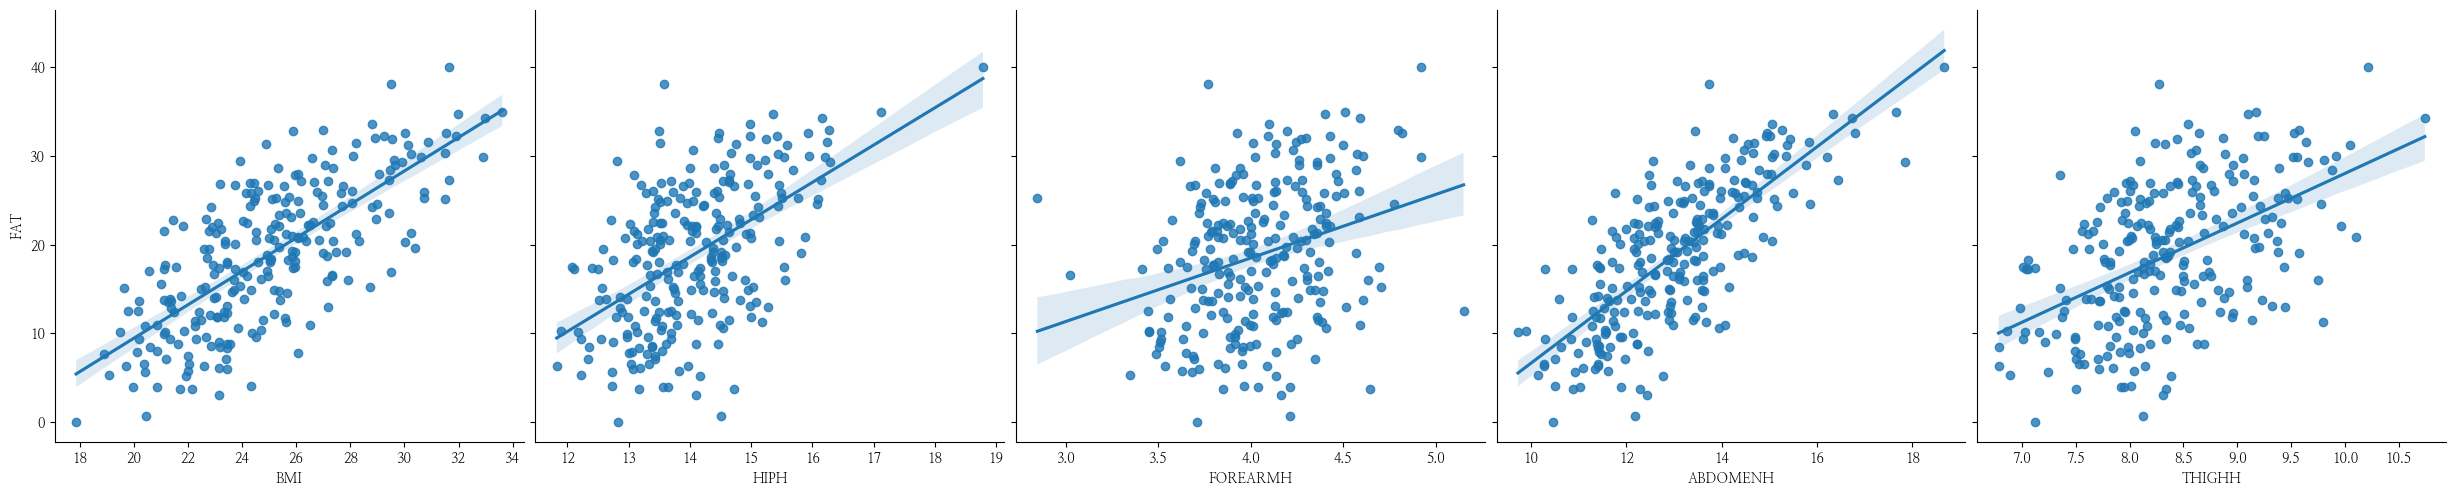

In [18]:
sns.pairplot(df_new, y_vars = 'FAT', x_vars=['BMI', 'HIPH', 'FOREARMH', 'ABDOMENH', 'THIGHH'], kind='reg', height = 5)

### 상관분석

In [19]:
df_new.corr().round(3)

,FAT,AGE,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
FAT,1.000,0.298,0.731,0.531,0.300,0.757,0.508
AGE,0.298,1.000,0.124,0.195,0.141,0.387,-0.000
BMI,0.731,0.124,1.000,0.663,0.461,0.801,0.685
HIPH,0.531,0.195,0.663,1.000,0.711,0.871,0.890
FOREARMH,0.300,0.141,0.461,0.711,1.000,0.608,0.673
ABDOMENH,0.757,0.387,0.801,0.871,0.608,1.000,0.771
THIGHH,0.508,-0.000,0.685,0.890,0.673,0.771,1.000


* NECK, CHEST, ABDOMEN, HIP, THING, BICEPS, BMI는 FAT과 높은 선형 관계가 있다.

In [20]:
df_new.head()

,FAT,AGE,BMI,HIPH,FOREARMH,ABDOMENH,THIGHH
0,35.0,65,33.616780,17.115358,4.507194,17.669399,9.179103
1,34.3,35,32.959928,16.158668,4.592008,16.736279,10.743565
2,29.9,37,32.915490,15.540204,4.024899,15.049030,9.523321
3,34.8,44,31.971390,15.354869,4.401442,16.329782,9.103961
4,32.3,41,31.923221,14.990034,4.092886,14.925478,9.192855


## 다중 선형 회귀 모델 생성

In [21]:
# data split
df_train, df_test = train_test_split(df_new, test_size = 0.3, random_state = 1234)

# 선형 회귀 분석
reg_model = smf.ols(formula = "FAT ~ AGE + BMI + ABDOMENH + HIPH + THIGHH + FOREARMH", data = df_train)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     63.56
Date:                Fri, 04 Nov 2022   Prob (F-statistic):           1.73e-40
Time:                        23:30:43   Log-Likelihood:                -505.74
No. Observations:                 173   AIC:                             1025.
Df Residuals:                     166   BIC:                             1048.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.0556      6.218     -1.135      0.2

* p-value : 0.05보다 매우 작기 때문에 회귀모델로서 유의
* 설명력 : 68.6%

### 다중공정성 검토

In [23]:
# 다중공정성 확인
df_train_x = df_train.drop('FAT', axis = 1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF", ascending = True).round(2)

,variable,VIF
1,AGE,1.77
4,FOREARMH,2.06
2,BMI,3.74
6,THIGHH,6.82
3,HIPH,9.14
5,ABDOMENH,9.46
0,const,316.72


다중공정성이 10이상인 변수가 없으므로 양호하다고 판단함

## 오차의 기본가정 검토

### 등분산성 검정

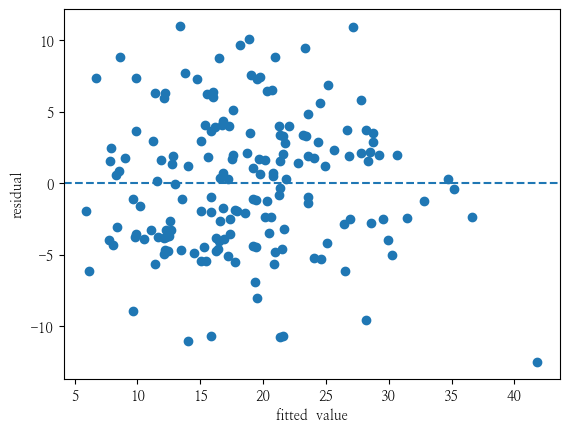

In [194]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted  value")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = '--')

* 잔차가 Y=0을 기준으로 random하게 산포되어 있어 등분산성을 만족하는 것으로 볼 수 있다.

### 정규성 검정

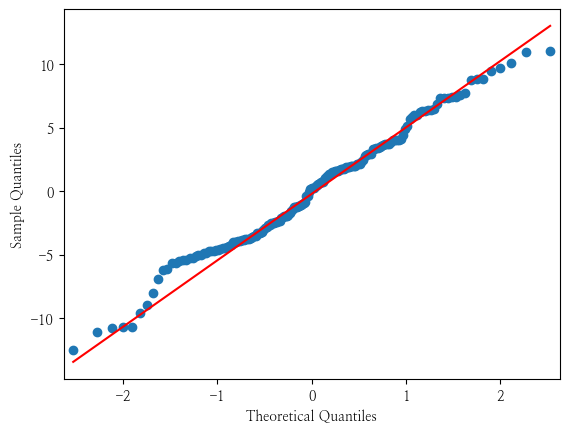

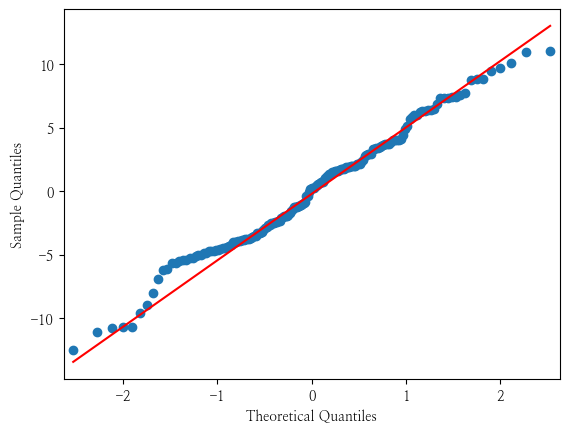

In [195]:
qqplot(reg_result.resid, line = "q")

* 정규분포 직선(적색 선)을 중심으로 분포하므로 정규분포를 따른다.

### 독립성 검정

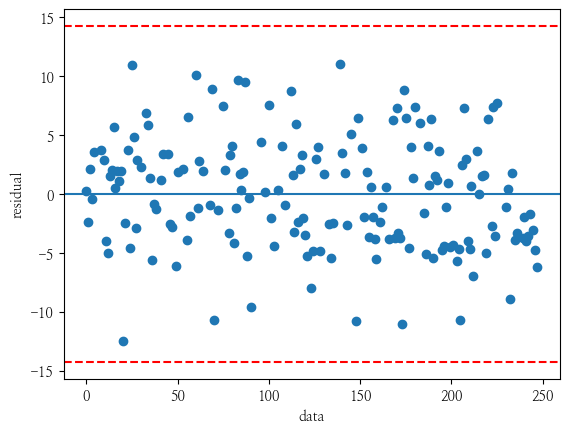

In [196]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("data")
plt.ylabel('residual')
plt.axhline(y=0, linestyle='-', label='CL')
plt.axhline(y=3*np.std(reg_result.resid),linestyle='--', color = 'red', label='UCL')
plt.axhline(y=-3*np.std(reg_result.resid),linestyle='--', color = 'red', label='LCL')

* 잔차가 y=0을 기준으로 관리상하한(UCL, LCL)을 벗어나지 않고 Random하게 산포되어 있어 독립성을 만족한다고 볼 수 있다.

## 결론

FAT와 파생변수들간의 상관관계
> Y[FAT] = 0.0276[AGE] + 0.9071[BMI] + 4.7272[ABDOMENH] - 3.7769[HIPH] + 0.9992[THIGHH] - 3.6986[FOREARMH] - 7.0556 
     
> [BMI] : WEIGHT / (HEIGHT^2)  
> [ABDOMENH] : ABDOMEN / (HEIGHT^2)  
> [HIPH] : HIP / (HEIGHT^2)  
> [THIGHH] : THIGH / (HEIGHT^2)  
> [FOREARMH] : FOREARM / (HEIGHT^2)  

> Train 결정계수 : 69.7%  
> Test 결정계수 : 68.6%

AGE : 27  
WEIGHT : 168.00  
HEIGHT : 71.25  
ABDOMEN : 79.1 	  
HIP : 94.5  
THIGH : 57.3  
FOREARM : 30  
일 때 FAT 예측치는?  
FAT : 9.58 (실제값 : 11.8)